Music Composition using Transformers

In [1]:
#Original code by:

#https://github.com/bearpelican/musicautobot/tree/15bc523548f8ae737a594ee92564538d02e0dc94

In [2]:
# Dataset from:

#http://www.jsbach.net/midi/midi_solo_violin.html
#https://bitmidi.com/eine-kleine-nachtmusik1-violin-mid

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
!git clone https://github.com/bearpelican/musicautobot.git
import os
os.chdir('musicautobot')

Cloning into 'musicautobot'...
remote: Enumerating objects: 4131, done.
remote: Total 4131 (delta 0), reused 0 (delta 0), pack-reused 4131
Receiving objects: 100% (4131/4131), 83.43 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (2992/2992), done.


In [5]:
from musicautobot.numpy_encode import *
!pip install pebble
!pip install git+https://github.com/fastai/fastai1.git
!pip install enum
from enum import Enum
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fastai/fastai1.git to /tmp/pip-req-build-w7yon3cu
  Running command git clone -q https://github.com/fastai/fastai1.git /tmp/pip-req-build-w7yon3cu
     |████████████████████████████████| 355 kB 29.4 MB/s 
  Created wheel for fastai: filename=fastai-1.0.64.dev0-py3-none-any.whl size=241906 sha256=e2ed322a2a1c93eee0cb4275b48942735d23ddd39e640aad5569505ec9f57099
  Stored in directory: /tmp/pip-ephem-wheel-cache-qigo3g7l/wheels/4f/26/4f/0cc93498278a4fdef45e8e73e848cceba2470a66ed895658e0
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=2730c204d099c3efa2a4ae8656b1bbd911ef930c06a912b3a43a8dcf6773741b
  Stored in directory: /root/.cache/pip/wheels/b9/b1/68/cb4feab29709d4155310d29a421389665dcab9eb3b679b527b
Successfully

In [6]:
!pip install musescore
print('installing lilypond...')
!apt-get install lilypond > /dev/null

print('installing musescore...')
!sudo apt-get install musescore

print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

import music21
from music21 import *
from IPython.display import Image, Audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
installing lilypond...
Extracting templates from packages: 100%
installing musescore...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  avahi-daemon bind9-host desktop-file-utils fluidr3mono-gm-soundfont
  geoclue-2.0 geoip-database gstreamer1.0-plugins-base iio-sensor-proxy
  libavahi-core7 libavahi-glib1 libbind9-160 libbrotli1 libcap2-bin
  libcdparanoia0 libdaemon0 libdns1100 libgeoclue-2-0 libgeoip1
  libgl1-mesa-glx libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0
  libisc169 libisccc160 libisccfg160 liblwres160 libmbim-glib4 libmbim-proxy
  libmm-glib0 libnl-genl-3-200 libnss-mdns liborc-0.4-0 libpam-cap
  libportaudio2 libpulsedsp 

In [7]:
environment.set('musescoreDirectPNGPath', '/usr/bin/musescore')

## MusicTransformer Training

MusicTransformer takes the basic idea of [Language Models](https://en.wikipedia.org/wiki/Language_model) and applies it to Music.  

Given a sequence of notes, predict the next most likely set of notes.

This model is based off of [transformer-XL](https://arxiv.org/abs/1901.02860) and uses fast.ai's [implementation](https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py) of it.

In [8]:
from google.colab import drive
drive.mount('/content/drive/')
#%cd content/drive/MyDrive/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/musicautobot

Mounted at /content/drive/


In [9]:
# Location of your midi filesfiles
midi_path = Path('/content/drive/MyDrive/DLASP/Proyecto_Final/MusicAutobot/musicautobot-master/musicautobot-master/data/midi')
midi_path.mkdir(parents=True, exist_ok=True)

# Location to save dataset
data_path = Path('data/numpy')
data_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'musicitem_data_save.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [10]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

22

In [11]:
processors = [Midi2ItemProcessor()]
data = MusicDataBunch.from_files(midi_files, data_path, processors=processors, bs=2, bptt=12)
data.save(data_save_name)

/usr/local/lib/python3.8/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [12]:
# Show Data
data.train_dl.on_epoch_begin()
x, y = data.one_batch();
x, y

(tensor([[[  0,   0],
          [  1,   0],
          [ 66,   0],
          [139,   0],
          [ 66,   0],
          [139,   0],
          [ 63,   0],
          [139,   0],
          [ 58,   0],
          [139,   0],
          [  8,   0],
          [141,   0]],
 
         [[138, 515],
          [ 73, 515],
          [138, 515],
          [ 69, 515],
          [138, 515],
          [ 57, 515],
          [138, 515],
          [  8, 515],
          [138, 515],
          [104, 516],
          [138, 516],
          [  8, 516]]]), tensor([[[  1,   0],
          [ 66,   0],
          [139,   0],
          [ 66,   0],
          [139,   0],
          [ 63,   0],
          [139,   0],
          [ 58,   0],
          [139,   0],
          [  8,   0],
          [141,   0],
          [ 66,   4]],
 
         [[ 73, 515],
          [138, 515],
          [ 69, 515],
          [138, 515],
          [ 57, 515],
          [138, 515],
          [  8, 515],
          [138, 515],
          [104, 516],
  

## 3. Load Model

In [13]:
# Create numpy and pretrained folder directly.
import os.path
from os import path

if path.exists('data/numpy/pretrained') == False:
  os.mkdir('data/numpy/pretrained')

In [14]:
# Pretrained Model
# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformerKeyC.pth'
# pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformer.pth'

pretrained_path = data_path/'pretrained'/Path(pretrained_url).name
download_url(pretrained_url, dest=pretrained_path)

In [15]:
batch_size = 1
encode_position = True
dl_tfms = [batch_position_tfm] if encode_position else []
data = load_data(data_path, data_save_name, bs=batch_size, encode_position=encode_position, dl_tfms=dl_tfms)

In [16]:
encode_position = True
config = default_config()
config['encode_position'] = encode_position
learn = music_model_learner(data, pretrained_path=pretrained_path, config=config.copy())

## 4. Train

In [17]:
#learn.fit_one_cycle(1)

In [18]:
#learn.save('example')

## 5. Predict

In [19]:
# Colab cannot play music directly from music21 - must convert to .wav first
!pip install midi2audio
from midi2audio import FluidSynth

def play_wav(stream):
    out_midi = stream.write('midi')
    out_wav = str(Path(out_midi).with_suffix('.wav'))
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

Predict without a starting sequence

In [43]:
vocab = data.vocab
empty_item = MusicItem.empty(vocab)

In [63]:
pred3, full = learn.predict(empty_item, n_words=400)

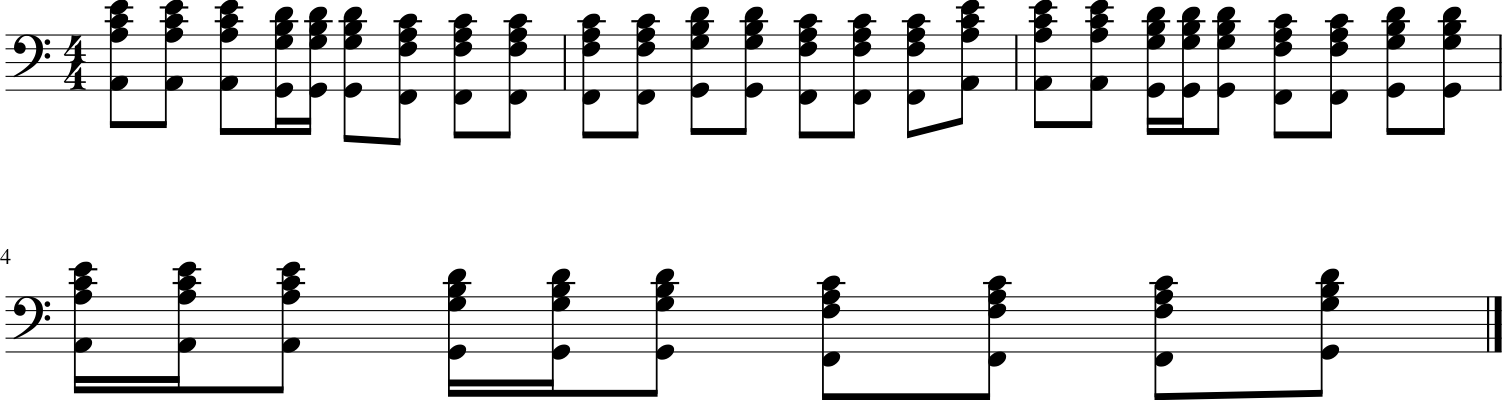

In [64]:
pred3.show()

In [65]:
pred3.play()
play_wav(pred3.stream)